# Hand Pose Model

จากโมเดลที่พัฒนาโดย Mediapipe ทำให้เราสามารถแสดงแบบจำลองของมือได้ โดยอาศัยการเรียนรู้ภาพต้นแบบสามมิติ จำนวน 30,000 ภาพ นำมาหาค่าพิกัดที่สำคัญ เพื่อใช้แสดงผลเป็นรูปทรงเรขาคณิตของมือจำนวน 21 พิกัด ดังรูป <br><br>

![hand_landmarks.png](https://raw.github.com/hengkp/mediapipe_examples/main/landmarks/hand_landmarks.png)<br><br>

ในการนับจำนวนนิ้วที่ยกจะถูกแบ่งเป็น 2 ส่วน ได้แก่ นิ้วโป้งและสี่นิ้วที่เหลือ (นิ้วชี้,นิ้วกลาง,นิ้วนาง,และนิ้วก้อย)

1. **นิ้วโป้ง** ทำการวัดระยะทางระหว่างปลายนิ้วโป้ง (ตำแหน่งที่ 4) เทียบกับส่วนต้นข้อต่อนิ้วก้อย (ตำแหน่งที่ 17) เปรียบเทียบกับความกว้างของฝ่ามือ (ตำแหน่งที่ 5 กับ 17) ในกรณีที่ระยะห่างของปลายนิ้วโป้ง *มากกว่า* ความกว้างของฝ่ามือ *บวกกับ* ครึ่งนึงของระยะของหัวนิ้วโป้ง (ตำแหน่งที่ 3 กับ 4) จะถูกนับว่านิ้วโป้งถูกยกขึ้น

2. **สี่นิ้วที่เหลือ** ทำการวัดระยะทางระหว่างปลายนิ้วแต่ละนิ้ว (ตำแหน่งที่ 8, 12, 16, 20) เทียบกับข้อมือ (ตำแหน่งที่ 0) เปรียบเทียบกับข้อต่อส่วนปลายของแต่ละนิ้ว (ตำแหน่งที่ 7, 11, 15, 19) เที่ยบกับข้อมือ (ตำแหน่งที่ 0) ในกรณีที่ระยะห่างของปลายนิ้ว *มากกว่า* ข้อต่อส่วนปลายนิ้ว จะนับว่านิ้วนั้นถูกยกขึ้น

<br>

**ตัวอย่างโค้ด**ด้านล่าง จะเป็นการเขียนโปรแกรมเพื่อใช้งานตัวโมเดลจาก Mediapipe ในการทำนายจำนวนนิ้วที่นับ และแสดงผลเป็นรูปภาพพร้อมจุดพิกัดและเส้นเชื่อมแสดงรูปทรงเรขาคณิตของมือ โดยประกอบด้วย 8 ขั้นตอนดังต่อไปนี้
<br><br>
![hand_workflow.jpg](https://raw.github.com/hengkp/mediapipe_examples/main/workflows/hand_workflow.jpg)


In [47]:
#@title **ขั้นตอนที่ 1** การนำเข้าโมเดลจาก Mediapipe

import requests
import os
import tensorflow as tf

# ที่อยู่ของโมเดลที่ต้องการนำเข้า
model_url = "https://storage.googleapis.com/mediapipe-assets/hand_landmark_lite.tflite"

# ดาวน์โหลดโมเดลมาเก็บไว้ที่เครื่อง
if not os.path.exists("hand_model.tflite"):
    response = requests.get(model_url)
    open("hand_model.tflite", "wb").write(response.content)

# นำเข้าโมเดล
model = tf.lite.Interpreter(model_path="hand_model.tflite")
model.allocate_tensors()

# เก็บข้อมูลข้อกำหนดของโมเดลสำหรับการเตรียมรูปภาพ
input_details = model.get_input_details()
output_details = model.get_output_details()

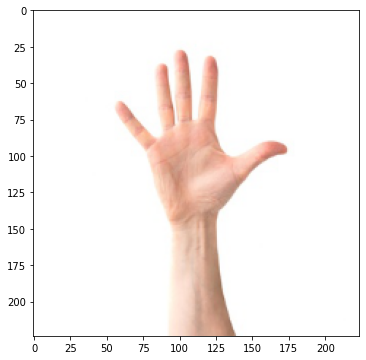

In [ ]:
#@title **ขั้นตอนที่ 2-4** นำเข้าและปรับขนาดของภาพให้สอดคล้องกับข้อกำหนดของโมเดล
from matplotlib import pyplot as plt
import numpy as np
import cv2
from skimage import io

# ใส่ที่อยู่ของภาพที่ต้องการนำเข้า
image_path = "https://raw.githubusercontent.com/hengkp/mediapipe_examples/main/datasets/hands/hand5.jpg"

# ขั้นตอนที่ 2 นำเข้าภาพ
img = io.imread(image_path)

# ขั้นตอนที่ 3 ปรับขนาดภาพให้สอดคล้องกับความต้องการของโมเดล
img = cv2.resize(img, (input_details[0]['shape'][1], input_details[0]['shape'][2])) # resize to match inputs of model

# ขั้นตอนที่ 4 ปรับสัดส่วนค่าสี (intensity) ให้อยู่ในช่วง 0 - 1
img = img / 255.0 # normalize image data
img = img.astype(np.float32)

# แสดงตัวอย่างภาพ
fig = plt.figure(figsize=(6, 6)) # define size of figure
plt.imshow(img) # display image in the figure
plt.show()

In [ ]:
#@title **ขั้นตอนที่ 5-6** ประมวลผลรูปผ่านโมเดลเพื่อทำนายจุดพิกัดสำคัญ

# ขั้นตอนที่ 5 ประมวลผลภาพ
model.set_tensor(input_details[0]['index'], [img])
model.invoke()

# ขั้นตอนที่ 6 ดึงข้อมูลพิกัดที่สำคัญที่ได้จากผลการประมวล
keypoints = model.get_tensor(output_details[0]['index'])
keypoints = np.squeeze(keypoints) # remove single-dimensional entries
keypoints = keypoints.reshape(-1, 3)[:, :-1] # reshape to (:, 2) only retrieve 'x' and 'y' axis

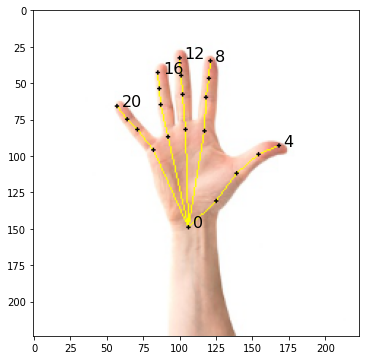

In [ ]:
#@title **ขั้นตอนที่ 7** แสดงผลรูปการทำนายมือ

from matplotlib import pyplot as plt

# เตรียมรูปภาพเพื่อแสดงผล
if np.max(img) <= 1:
    img = (img * 255).astype(np.uint8) # convert image back to [0..255] format
fig, ax = plt.subplots(figsize=(6, 6)) # define size of figure

# วาดเส้นเชื่อมระหว่างพิกัด
keypoints_pairs = [(0, 1), (1, 2), (2, 3), (3, 4), 
                   (0, 5), (5, 6), (6, 7), (7, 8), 
                   (0, 9), (9, 10), (10, 11), (11, 12), 
                   (0, 13), (13, 14), (14, 15), (15, 16), 
                   (0, 17), (17, 18), (18, 19), (19, 20)]
for pair in keypoints_pairs: # loop each key pair to draw line
    x1, y1 = int(keypoints[pair[0],0]), int(keypoints[pair[0],1])
    x2, y2 = int(keypoints[pair[1],0]), int(keypoints[pair[1],1])
    cv2.line(img, (x1, y1), (x2, y2), (255, 255, 0), 1) # draw a line

# วาดจุดพิกัดลงในภาพ
for i in range(keypoints.shape[0]): # loop all keypoints [0,1,2,...,20]
    kp = (int(keypoints[i,0]), int(keypoints[i,1]))
    cv2.circle(img, kp, 1, (0, 0, 0), -1)

# ใส่หมายเลขบอกพิกัด
for i in range(0, keypoints.shape[0], 4): # loop palm and only tips of each finger (0,4,8,12,16,20)
    kp = (int(keypoints[i,0]), int(keypoints[i,1]))
    ax.annotate(i, kp, fontsize=16, xytext=(5,0), textcoords='offset points') # write text of keypoint ID

# แสดงผลรูปภาพพร้อมพิกัด
plt.imshow(img)
plt.show()

In [ ]:
#@title **ขั้นตอนที่ 8** แสดงผลค่าจำนวนนิ้วที่นับได้

# กำหนดตำแหน่งฝ่ามือ
# กำหนดตำแหน่งข้อนิ้วและปลายนิ้วทั้งสี่ ได้แก่ นิ้วชี้ นิ้วกลาง นิ้วนาง และ นิ้วก้อย
palm = 0
tips = [8, 12, 16, 20]
joints = [6, 10, 14, 18]

# วัดระยะปลายนิ้วทั้งสี่ เทียบกับ ระยะของฝ่ามือ
# โดยกำหนดจากระยะของฝ่ามือเป็นหลัก
tips_distance = np.linalg.norm(keypoints[tips] - keypoints[palm], axis=1)
joints_distance = np.linalg.norm(keypoints[joints] - keypoints[palm], axis=1)
tips_joints_distance = tips_distance - joints_distance

# วัดระยะปลายนิ้วโป้งที่แยกออกจากฝ่ามือ
# โดยกำหนดจากระยะของข้อนิ้วก้อยเป็นหลัก
thumb_pinky = np.linalg.norm(keypoints[4] - keypoints[17])
index_pinky = np.linalg.norm(keypoints[5] - keypoints[17])
thumb_length = np.linalg.norm(keypoints[4] - keypoints[3])
thumb_distance = thumb_pinky - index_pinky

# สรุปผลจำนวนนิ้วที่นับได้ โดย
# ถ้าปลายนิ้วยาวกว่าฝ่ามือจะถูกนับว่านิ้วนั้นยกขึ้น
# และถ้านิ้วโป้งแยกจากฝ่ามือจะถูกนับว่านิ้วโป้งยกขึ้น
fingers = (thumb_distance >= thumb_length/2) + sum(x >= 0 for x in tips_joints_distance)

# แสดงผลจำนวนนิ้วที่นับได้
print("Number of fingers:", fingers)

Number of fingers: 5
